# Inference on Predictive and Causal Effects in High-Dimensional Nonlinear Models

## Impact of 401(k) on  Financial Wealth

As a practical illustration of the DML method, we consider estimation of the effect of 401(k) eligibility and participation
on accumulated assets. 401(k) plans are pension accounts sponsored by employers. The key problem in determining the effect of participation in 401(k) plans on accumulated assets is saver heterogeneity coupled with the fact that the decision to enroll in a 401(k) is non-random. It is generally recognized that some people have a higher preference for saving than others. It also seems likely that those individuals with high unobserved preference for saving would be most likely to choose to participate in tax-advantaged retirement savings plans and would tend to have otherwise high amounts of accumulated assets. The presence of unobserved savings preferences with these properties then implies that conventional estimates that do not account for saver heterogeneity and endogeneity of participation will be biased upward, tending to overstate the savings effects of 401(k) participation.

One can argue that eligibility for enrolling in a 401(k) plan in this data can be taken as exogenous after conditioning on a few observables of which the most important for their argument is income. The basic idea is that, at least around the time 401(k)’s initially became available, people were unlikely to be basing their employment decisions on whether an employer offered a 401(k) but would instead focus on income and other aspects of the job.

### Data

The data set can be downloaded from the github repo


In [2]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV, LinearRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.base import TransformerMixin, BaseEstimator, clone
from IPython.display import Markdown
import wget
import seaborn as sns
from formulaic import Formula
import warnings
warnings.simplefilter('ignore')
np.random.seed(1234)

In [3]:
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.csv"
data = pd.read_csv(file)

In [4]:
data.describe()

,ira,a401,hval,hmort,hequity,nifa,net_nifa,tfa,net_tfa,tfa_he,...,i3,i4,i5,i6,i7,a1,a2,a3,a4,a5
count,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9.915000e+03,9.915000e+03,9.915000e+03,9.915000e+03,9.915000e+03,...,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000
mean,3462.871609,3990.459304,63595.865759,30022.505093,33573.360666,1.392864e+04,1.041415e+04,2.156603e+04,1.805153e+04,5.162490e+04,...,0.209178,0.172668,0.121432,0.158548,0.077358,0.144024,0.209682,0.297428,0.215431,0.133434
std,9648.027853,12825.840676,73679.374267,40056.879558,51830.770524,5.490488e+04,5.602886e+04,6.256504e+04,6.352250e+04,9.325339e+04,...,0.406742,0.377979,0.326645,0.365272,0.267171,0.351132,0.407102,0.457150,0.411142,0.340061
min,0.000000,0.000000,0.000000,0.000000,-40000.000000,0.000000e+00,-5.023020e+05,0.000000e+00,-5.023020e+05,-5.023020e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+02,-1.350000e+03,3.750000e+02,-5.000000e+02,2.000000e+02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,48000.000000,7000.000000,10000.000000,1.635000e+03,2.700000e+02,3.325000e+03,1.499000e+03,1.850000e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,200.000000,95000.000000,50000.000000,46650.000000,8.765500e+03,6.543500e+03,1.908450e+04,1.652450e+04,6.920000e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,100000.000000,153000.000000,300000.000000,150000.000000,300000.000000,1.430298e+06,1.430298e+06,1.536798e+06,1.536798e+06,1.687115e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  
data.head()

,ira,a401,hval,hmort,hequity,nifa,net_nifa,tfa,net_tfa,tfa_he,tw,age,inc,fsize,educ,db,marr,male,twoearn,dum91,e401,p401,pira,nohs,hs,smcol,col,icat,ecat,zhat,net_n401,hown,i1,i2,i3,i4,i5,i6,i7,a1,a2,a3,a4,a5
0,0,0,69000,60150,8850,100,-3300,100,-3300,5550,53550,31,28146,5,12,0,1,0,0,1,0,0,0,0,1,0,0,3,2,0.273178,-3300,1,0,0,1,0,0,0,0,0,1,0,0,0
1,0,0,78000,20000,58000,61010,61010,61010,61010,119010,124635,52,32634,5,16,0,0,0,0,1,0,0,0,0,0,0,1,4,4,0.386641,61010,1,0,0,0,1,0,0,0,0,0,0,1,0
2,1800,0,200000,15900,184100,7549,7049,9349,8849,192949,192949,50,52206,3,11,0,1,1,1,1,0,0,1,1,0,0,0,6,1,0.533650,8849,1,0,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,2487,-6013,2487,-6013,-6013,-513,28,45252,4,15,0,1,0,1,1,0,0,0,0,0,1,0,5,3,0.324319,-6013,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0,0,300000,90000,210000,10625,-2375,10625,-2375,207625,212087,42,33126,3,12,1,0,0,0,1,0,0,0,0,1,0,0,4,2,0.602807,-2375,1,0,0,0,1,0,0,0,0,0,1,0,0


In [5]:
readme = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.md"
filename = wget.download(readme)
Markdown(open(filename, 'r').read())

# Pension 401(k) data set

## Description
Data set on financial wealth and 401(k) plan participation. The source of this data set is the `hdm` package in `R`. It was created on 2/20/2023, by calling the `data(pension)` command in `R` after loading the `hdm` package and then writing the created dataframe to a csv file.

## Format
Dataframe with the following variables (amongst others):

**p401**

participation in 401(k)

**e401**

eligibility for 401(k)

**a401**

401(k) assets

**tw**

total wealth (in US $)

**tfa**

financial assets (in US $)

**net_tfa**

net financial assets (in US $)

**nifa**

non-401k financial assets (in US $)

**net_nifa**

net non-401k financial assets

**net_n401**

net non-401(k) assets (in US $)

**ira**

individual retirement account (IRA)

**inc**

income (in US $)

**age**

age

**fsize**

family size

**marr**

married

**pira**

participation in IRA

**db**

defined benefit pension

**hown**

home owner

**educ**

education (in years)

**male**

male

**twoearn**

two earners

**nohs, hs, smcol, col**

dummies for education: no high-school, high-school, some college, college

**hmort**

home mortage (in US $)

**hequity**

home equity (in US $)

**hval**

home value (in US $)

**i1-i7**

are income category indicators, 

**a1-a5**

are age category indicators

**icat** 

is the categorical variable that produces i1-i7. 

**ecat** 

is the categorical variable that generates education dummies (no high school, high school, some college, college). 

**Dum91**

is a dummy for 1991 which is equal to 1 for all observations because we are only use the 1991 SIPP. 

**tfa_he**

is net_tfa + home equity.

**zhat**

outcome of first stage prediction in instrumental variable analysis, from the academic paper that introduced this data


## Details
The sample is drawn from the 1991 Survey of Income and Program Participation (SIPP) and consists of 9,915 observations. The observational units are household reference persons aged 25-64 and spouse if present. Households are included in the sample if at least one person is employed and no one is self-employed. The data set was analysed in Chernozhukov and Hansen (2004) and Belloni et al. (2014) where further details can be found. They examine the effects of 401(k) plans on wealth using data from the Survey of Income and Program Participation using 401(k) eligibility as an instrument for 401(k) participation.

## References
V. Chernohukov, C. Hansen (2004). The impact of 401(k) participation on the wealth distribution: An instrumental quantile regression analysis. The Review of Economic and Statistics 86 (3), 735–751.

A. Belloni, V. Chernozhukov, I. Fernandez-Val, and C. Hansen (2014). Program evaluation with high-dimensional data. Working Paper.

The data consist of 9,915 observations at the household level drawn from the 1991 Survey of Income and Program Participation (SIPP). We use net financial assets (*net\_tfa*) as the outcome variable, $Y$,  in our analysis. The net financial assets are computed as the sum of IRA balances, 401(k) balances, checking accounts, saving bonds, other interest-earning accounts, other interest-earning assets, stocks, and mutual funds less non mortgage debts.

Among the $9915$ individuals, $3682$ are eligible to participate in the program. The variable *e401* indicates eligibility and *p401* indicates participation, respectively.

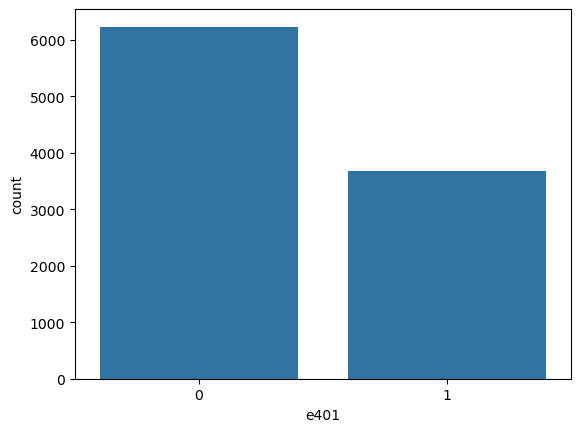

In [6]:
sns.countplot(data, x='e401')
plt.show()

Eligibility is highly associated with financial wealth:

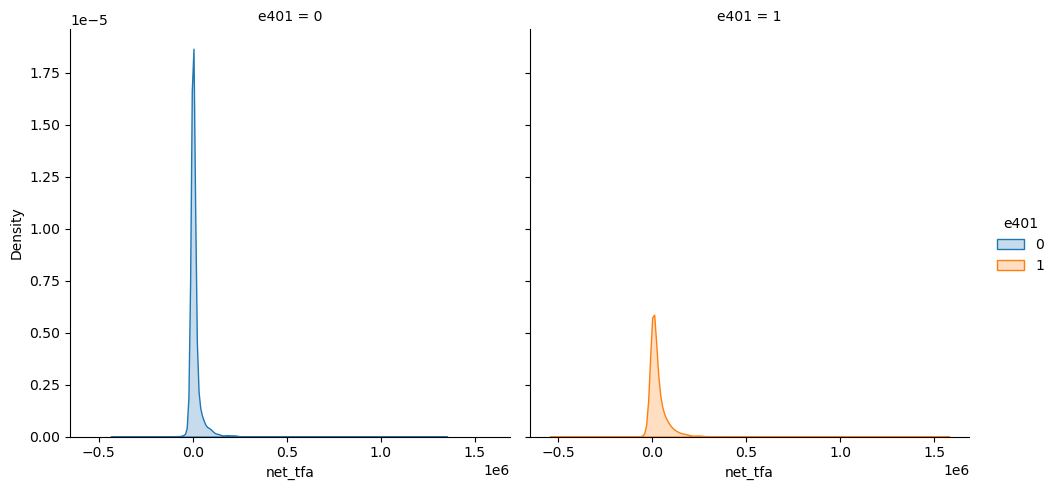

In [7]:
sns.displot(data=data, x='net_tfa', kind='kde', col='e401', hue='e401', fill=True)
plt.show()

The unconditional APE of e401 is about $19559$:

In [8]:
e1 = data[data['e401'] == 1]['net_tfa']
e0 = data[data['e401'] == 0]['net_tfa']
print(f'{np.mean(e1) - np.mean(e0):.0f}')

19559


Among the $3682$ individuals that  are eligible, $2594$ decided to participate in the program. The unconditional APE of p401 is about $27372$:

In [9]:
e1 = data[data['p401'] == 1]['net_tfa']
e0 = data[data['p401'] == 0]['net_tfa']
print(f'{np.mean(e1) - np.mean(e0):.0f}')

27372


As discussed, these estimates are biased since they do not account for saver heterogeneity and endogeneity of participation.

In [10]:
y = data['net_tfa'].values
D = data['e401'].values
D2 = data['p401'].values
D3 = data['a401'].values
X = data.drop(['e401', 'p401', 'a401', 'tw', 'tfa', 'net_tfa', 'tfa_he',
               'hval', 'hmort', 'hequity',
               'nifa', 'net_nifa', 'net_n401', 'ira',
               'dum91', 'icat', 'ecat', 'zhat',
               'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7',
               'a1', 'a2', 'a3', 'a4', 'a5'], axis=1)
X.columns

Index(['age', 'inc', 'fsize', 'educ', 'db', 'marr', 'male', 'twoearn', 'pira',
       'nohs', 'hs', 'smcol', 'col', 'hown'],
      dtype='object')

### We define a transformer that constructs the engineered features for controls

In [11]:
class FormulaTransformer(TransformerMixin, BaseEstimator):

    def __init__(self, formula, array=False):
        self.formula = formula
        self.array = array

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = Formula(self.formula).get_model_matrix(X)
        if self.array:
            return df.values
        return df

In [12]:
transformer = FormulaTransformer("0 + poly(age, degree=6, raw=True) + poly(inc, degree=8, raw=True) "
                                 "+ poly(educ, degree=4, raw=True) + poly(fsize, degree=2, raw=True) "
                                 "+ male + marr + twoearn + db + pira + hown")

In [13]:
transformer.fit_transform(X).describe()

,"poly(age, degree=6, raw=True)[0]","poly(age, degree=6, raw=True)[1]","poly(age, degree=6, raw=True)[2]","poly(age, degree=6, raw=True)[3]","poly(age, degree=6, raw=True)[4]","poly(age, degree=6, raw=True)[5]","poly(inc, degree=8, raw=True)[0]","poly(inc, degree=8, raw=True)[1]","poly(inc, degree=8, raw=True)[2]","poly(inc, degree=8, raw=True)[3]",...,"poly(educ, degree=4, raw=True)[2]","poly(educ, degree=4, raw=True)[3]","poly(fsize, degree=2, raw=True)[0]","poly(fsize, degree=2, raw=True)[1]",male,marr,twoearn,db,pira,hown
count,9915.000000,9915.000000,9915.000000,9.915000e+03,9.915000e+03,9.915000e+03,9915.000000,9.915000e+03,9.915000e+03,9.915000e+03,...,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000
mean,41.060212,1792.938981,82850.255371,4.022991e+06,2.036867e+08,1.067384e+10,37200.623197,1.997590e+09,1.437534e+14,9.104568e+17,...,2601.853757,38237.377912,2.865860,10.581241,0.205951,0.604841,0.380837,0.271004,0.242158,0.635199
std,10.344505,899.134499,61725.701911,3.939869e+06,2.448502e+08,1.507229e+10,24774.288006,3.026128e+09,4.129207e+14,3.249753e+18,...,1464.892397,28259.732691,1.538937,11.391608,0.404415,0.488909,0.485617,0.444500,0.428411,0.481399
min,25.000000,625.000000,15625.000000,3.906250e+05,9.765625e+06,2.441406e+08,-2652.000000,0.000000e+00,-1.865179e+10,-9.222694e+18,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,1024.000000,32768.000000,1.048576e+06,3.355443e+07,1.073742e+09,19413.000000,3.768646e+08,7.316072e+12,3.677463e+16,...,1728.000000,20736.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,1600.000000,64000.000000,2.560000e+06,1.024000e+08,4.096000e+09,31476.000000,9.907386e+08,3.118449e+13,4.226261e+17,...,1728.000000,20736.000000,3.000000,9.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,48.000000,2304.000000,110592.000000,5.308416e+06,2.548040e+08,1.223059e+10,48583.500000,2.360356e+09,1.146744e+14,2.117477e+18,...,4096.000000,65536.000000,4.000000,16.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,64.000000,4096.000000,262144.000000,1.677722e+07,1.073742e+09,6.871948e+10,242124.000000,5.862403e+10,1.419428e+16,9.222042e+18,...,5832.000000,104976.000000,13.000000,169.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
transformer = FormulaTransformer("0 + poly(age, degree=6, raw=True) + poly(inc, degree=8, raw=True) "
                                 "+ poly(educ, degree=4, raw=True) + poly(fsize, degree=2, raw=True) "
                                 "+ male + marr + twoearn + db + pira + hown", array=True)

## Estimating the ATE of 401(k) Eligibility on Net Financial Assets

We are interested in valid estimators of the average treatment effect of `e401` and `p401` on `net_tfa`. We start using ML approaches to estimate the function $g_0$ and $m_0$ in the following PLR model:

\begin{split}
 Y = D\theta_0 + g_0(X) + \zeta,  &  ~~E[\zeta \mid D,X]= 0,\\
 D = m_0(X) +  V,   & ~~ E[V \mid X] = 0.
\end{split}

### Double ML in PLR with Cross-Fitting

We define a simple dml function that is parameterized by arbitrary ML models and returns the treatment effect and other useful quantities of the analysis

In [15]:
def dml(X, D, y, modely, modeld, *, nfolds, classifier=False):
    '''
    DML for the Partially Linear Model setting with cross-fitting

    Input
    -----
    X: the controls
    D: the treatment
    y: the outcome
    modely: the ML model for predicting the outcome y
    modeld: the ML model for predicting the treatment D
    nfolds: the number of folds in cross-fitting
    classifier: bool, whether the modeld is a classifier or a regressor

    Output
    ------
    point: the point estimate of the treatment effect of D on y
    stderr: the standard error of the treatment effect
    yhat: the cross-fitted predictions for the outcome y
    Dhat: the cross-fitted predictions for the treatment D
    resy: the outcome residuals
    resD: the treatment residuals
    epsilon: the final residual-on-residual OLS regression residual
    '''
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=123)  # shuffled k-folds
    yhat = cross_val_predict(modely, X, y, cv=cv, n_jobs=-1)  # out-of-fold predictions for y
    # out-of-fold predictions for D
    # use predict or predict_proba dependent on classifier or regressor for D
    if classifier:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    else:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, n_jobs=-1)
    # calculate outcome and treatment residuals
    resy = y - yhat
    resD = D - Dhat

    # final stage ols based point estimate and standard error
    point = np.mean(resy * resD) / np.mean(resD**2)
    epsilon = resy - point * resD
    var = np.mean(epsilon**2 * resD**2) / np.mean(resD**2)**2
    stderr = np.sqrt(var / X.shape[0])

    return point, stderr, yhat, Dhat, resy, resD, epsilon

In [16]:
def summary(point, stderr, yhat, Dhat, resy, resD, epsilon, X, D, y, *, name):
    '''
    Convenience summary function that takes the results of the DML function
    and summarizes several estimation quantities and performance metrics.
    '''
    return pd.DataFrame({'estimate': point,  # point estimate
                         'stderr': stderr,  # standard error
                         'lower': point - 1.96 * stderr,  # lower end of 95% confidence interval
                         'upper': point + 1.96 * stderr,  # upper end of 95% confidence interval
                         'rmse y': np.sqrt(np.mean(resy**2)),  # RMSE of model that predicts outcome y
                         'rmse D': np.sqrt(np.mean(resD**2)),  # RMSE of model that predicts treatment D
                         'accuracy D': np.mean(np.abs(resD) < .5),  # binary classification accuracy of model for D
                         }, index=[name])

#### Double Lasso with Cross-Fitting

In [17]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
lassoy = make_pipeline(transformer, StandardScaler(), LassoCV(cv=cv))
lassod = make_pipeline(transformer, StandardScaler(), LassoCV(cv=cv))
result = dml(X, D, y, lassoy, lassod, nfolds=5)

In [18]:
table = summary(*result, X, D, y, name='double lasso')
table

,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
double lasso,9035.120004,1295.135748,6496.653938,11573.58607,54254.468883,0.443406,0.688553


#### Using a Penalized Logistic Regression for D

Note the default logistic regression uses an $\ell_2$ penalty. You can use the $\ell_1$ penalty as well, but computation will take longer.

In [19]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
lassoy = make_pipeline(transformer, StandardScaler(), LassoCV(cv=cv))
lgrd = make_pipeline(transformer, StandardScaler(), LogisticRegressionCV(cv=cv))
result = dml(X, D, y, lassoy, lgrd, nfolds=5, classifier=True)

In [20]:
summary(*result, X, D, y, name='lasso/logistic')

,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
lasso/logistic,9092.469504,1304.404612,6535.836464,11649.102543,54254.468883,0.444043,0.687847


In [21]:
table = pd.concat([table, summary(*result, X, D, y, name='lasso/logistic')])
table

,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
double lasso,9035.120004,1295.135748,6496.653938,11573.586070,54254.468883,0.443406,0.688553
lasso/logistic,9092.469504,1304.404612,6535.836464,11649.102543,54254.468883,0.444043,0.687847


Then, we repeat this procedure for various machine learning methods.

### Random Forests

In [22]:
rfy = make_pipeline(transformer, RandomForestRegressor(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
rfd = make_pipeline(transformer, RandomForestClassifier(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
result = dml(X, D, y, rfy, rfd, nfolds=5, classifier=True)

In [23]:
table = pd.concat([table, summary(*result, X, D, y, name='random forest')])
table

,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
double lasso,9035.120004,1295.135748,6496.653938,11573.586070,54254.468883,0.443406,0.688553
lasso/logistic,9092.469504,1304.404612,6535.836464,11649.102543,54254.468883,0.444043,0.687847
random forest,8858.855700,1357.128634,6198.883578,11518.827822,55050.908411,0.444420,0.690570


### Decision Trees

In [24]:
dtry = make_pipeline(transformer, DecisionTreeRegressor(min_samples_leaf=10, ccp_alpha=.001))
dtrd = make_pipeline(transformer, DecisionTreeClassifier(min_samples_leaf=10, ccp_alpha=.001))
result = dml(X, D, y, dtry, dtrd, nfolds=5, classifier=True)

In [25]:
table = pd.concat([table, summary(*result, X, D, y, name='decision tree')])
table

,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
double lasso,9035.120004,1295.135748,6496.653938,11573.586070,54254.468883,0.443406,0.688553
lasso/logistic,9092.469504,1304.404612,6535.836464,11649.102543,54254.468883,0.444043,0.687847
random forest,8858.855700,1357.128634,6198.883578,11518.827822,55050.908411,0.444420,0.690570
decision tree,9236.195678,1440.551643,6412.714457,12059.676898,59427.392172,0.446437,0.688048


### Boosted Trees

In [26]:
gbfy = make_pipeline(transformer, GradientBoostingRegressor(max_depth=2, n_iter_no_change=5))
gbfd = make_pipeline(transformer, GradientBoostingClassifier(max_depth=2, n_iter_no_change=5))
result = dml(X, D, y, gbfy, gbfd, nfolds=5, classifier=True)

In [27]:
table = pd.concat([table, summary(*result, X, D, y, name='boosted forest')])
table

,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
double lasso,9035.120004,1295.135748,6496.653938,11573.586070,54254.468883,0.443406,0.688553
lasso/logistic,9092.469504,1304.404612,6535.836464,11649.102543,54254.468883,0.444043,0.687847
random forest,8858.855700,1357.128634,6198.883578,11518.827822,55050.908411,0.444420,0.690570
decision tree,9236.195678,1440.551643,6412.714457,12059.676898,59427.392172,0.446437,0.688048
boosted forest,8865.489082,1348.395763,6222.633386,11508.344778,56028.952986,0.443331,0.690066


The best model with lowest RMSE in both equation is the PLR model estimated via lasso.

### AutoML

In [28]:
from flaml import AutoML
flamly = make_pipeline(transformer, AutoML(time_budget=100, task='regression', early_stop=True,
                                           eval_method='cv', n_splits=3, metric='r2', verbose=3))
flamld = make_pipeline(transformer, AutoML(time_budget=100, task='classification', early_stop=True,
                                           eval_method='cv', n_splits=3, metric='r2', verbose=3))
result = dml(X, D, y, flamly, flamld, nfolds=5, classifier=True)

In [29]:
table = pd.concat([table, summary(*result, X, D, y, name='automl')])
table

,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
double lasso,9035.120004,1295.135748,6496.653938,11573.586070,54254.468883,0.443406,0.688553
lasso/logistic,9092.469504,1304.404612,6535.836464,11649.102543,54254.468883,0.444043,0.687847
random forest,8858.855700,1357.128634,6198.883578,11518.827822,55050.908411,0.444420,0.690570
decision tree,9236.195678,1440.551643,6412.714457,12059.676898,59427.392172,0.446437,0.688048
boosted forest,8865.489082,1348.395763,6222.633386,11508.344778,56028.952986,0.443331,0.690066
automl,8815.116779,1336.129857,6196.302260,11433.931298,55539.308058,0.444316,0.688553


# Semi-Cross-Fitting

To avoid the computational cost of performing model selection within each fold (assuming that we don't select among an exponential set of hyperparameters/models in the number of samples), it is ok to perform model selection using all the data and then perform cross-fitting with the selected model.

In [30]:
flamly = make_pipeline(transformer, AutoML(time_budget=100, task='regression', early_stop=True,
                                           eval_method='cv', n_splits=3, metric='r2', verbose=0))
flamld = make_pipeline(transformer, AutoML(time_budget=100, task='classification', early_stop=True,
                                           eval_method='cv', n_splits=3, metric='r2', verbose=0))

In [31]:
flamly.fit(X, y)
besty = make_pipeline(transformer, clone(flamly[-1].best_model_for_estimator(flamly[-1].best_estimator)))

In [32]:
flamld.fit(X, D)
bestd = make_pipeline(transformer, clone(flamld[-1].best_model_for_estimator(flamld[-1].best_estimator)))

In [33]:
result = dml(X, D, y, besty, bestd, nfolds=5, classifier=True)

In [34]:
table = pd.concat([table, summary(*result, X, D, y, name='automl (semi-cfit)')])
table

,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
double lasso,9035.120004,1295.135748,6496.653938,11573.586070,54254.468883,0.443406,0.688553
lasso/logistic,9092.469504,1304.404612,6535.836464,11649.102543,54254.468883,0.444043,0.687847
random forest,8858.855700,1357.128634,6198.883578,11518.827822,55050.908411,0.444420,0.690570
decision tree,9236.195678,1440.551643,6412.714457,12059.676898,59427.392172,0.446437,0.688048
boosted forest,8865.489082,1348.395763,6222.633386,11508.344778,56028.952986,0.443331,0.690066
automl,8815.116779,1336.129857,6196.302260,11433.931298,55539.308058,0.444316,0.688553
automl (semi-cfit),9096.901818,1305.992620,6537.156283,11656.647353,53899.822340,0.445611,0.691679


### Semi-Crossfitting with Stacking

In [35]:
def dml_dirty(X, D, y, modely_list, modeld_list, *,
              stacker=LinearRegression(), nfolds, classifier=False):
    '''
    DML for the Partially Linear Model setting with semi-cross-fitting

    Input
    -----
    X: the controls
    D: the treatment
    y: the outcome
    modely: the ML model for predicting the outcome y
    modeld: the ML model for predicting the treatment D
    stacker: model used to aggregate predictions of each of the base models
    nfolds: the number of folds in cross-fitting
    classifier: bool, whether the modeld is a classifier or a regressor

    Output
    ------
    point: the point estimate of the treatment effect of D on y
    stderr: the standard error of the treatment effect
    yhat: the cross-fitted predictions for the outcome y
    Dhat: the cross-fitted predictions for the treatment D
    resy: the outcome residuals
    resD: the treatment residuals
    epsilon: the final residual-on-residual OLS regression residual
    '''
    # construct out-of-fold predictions for each model
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=123)
    yhats = np.array([cross_val_predict(modely, X, y, cv=cv, n_jobs=-1) for modely in modely_list]).T
    if classifier:
        Dhats = np.array([cross_val_predict(modeld, X, D, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
                         for modeld in modeld_list]).T
    else:
        Dhats = np.array([cross_val_predict(modeld, X, D, cv=cv, n_jobs=-1) for modeld in modeld_list]).T
    # calculate stacked residuals by finding optimal coefficients
    # and weigthing out-of-sample predictions by these coefficients
    yhat = stacker.fit(yhats, y).predict(yhats)
    Dhat = stacker.fit(Dhats, D).predict(Dhats)
    resy = y - yhat
    resD = D - Dhat
    # go with the stacked residuals
    point = np.mean(resy * resD) / np.mean(resD**2)
    epsilon = resy - point * resD
    var = np.mean(epsilon**2 * resD**2) / np.mean(resD**2)**2
    stderr = np.sqrt(var / X.shape[0])
    return point, stderr, yhat, Dhat, resy, resD, epsilon

In [36]:
result = dml_dirty(X, D, y, [lassoy, rfy, dtry, gbfy], [lgrd, rfd, dtrd, gbfd],
                   nfolds=5, classifier=True)

In [37]:
table = pd.concat([table, summary(*result, X, D, y, name='stacked (semi-cfit)')])
table

,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
double lasso,9035.120004,1295.135748,6496.653938,11573.586070,54254.468883,0.443406,0.688553
lasso/logistic,9092.469504,1304.404612,6535.836464,11649.102543,54254.468883,0.444043,0.687847
random forest,8858.855700,1357.128634,6198.883578,11518.827822,55050.908411,0.444420,0.690570
decision tree,9236.195678,1440.551643,6412.714457,12059.676898,59427.392172,0.446437,0.688048
boosted forest,8865.489082,1348.395763,6222.633386,11508.344778,56028.952986,0.443331,0.690066
automl,8815.116779,1336.129857,6196.302260,11433.931298,55539.308058,0.444316,0.688553
automl (semi-cfit),9096.901818,1305.992620,6537.156283,11656.647353,53899.822340,0.445611,0.691679
stacked (semi-cfit),8956.279433,1307.282748,6394.005247,11518.553619,53977.538601,0.442859,0.689662


## Interactive Regression Model (IRM)

Next, we consider estimation of average treatment effects when treatment effects are fully heterogeneous:

 \begin{split}
  Y  = g_0(D, X) + U,  &  \quad E[U \mid X, D]= 0,\\
  D  = m_0(X) + V,  & \quad  E[V\mid X] = 0.
\end{split}

To reduce the disproportionate impact of extreme propensity score weights in the interactive model
we trim the propensity scores which are below .01 or above .99.

In [38]:
def dr(X, D, y, modely0, modely1, modeld, *, trimming=0.01, nfolds):
    '''
    DML for the Interactive Regression Model setting (Doubly Robust Learning)
    with cross-fitting

    Input
    -----
    X: the controls
    D: the treatment
    y: the outcome
    modely0: the ML model for predicting the outcome y in the control population
    modely1: the ML model for predicting the outcome y in the treated population
    modeld: the ML model for predicting the treatment D
    trimming: threshold below which to trim propensities
    nfolds: the number of folds in cross-fitting

    Output
    ------
    point: the point estimate of the treatment effect of D on y
    stderr: the standard error of the treatment effect
    yhat: the cross-fitted predictions for the outcome y
    Dhat: the cross-fitted predictions for the outcome D
    resy: the outcome residuals
    resD: the treatment residuals
    drhat: the doubly robust quantity for each sample
    '''
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=123)
    yhat0, yhat1 = np.zeros(y.shape), np.zeros(y.shape)
    # we will fit a model E[Y| D, X] by fitting a separate model for D==0
    # and a separate model for D==1.
    for train, test in cv.split(X, y):
        # train a model on training data that received treatment zero and predict on all data in test set
        yhat0[test] = clone(modely0).fit(X.iloc[train][D[train] == 0], y[train][D[train] == 0]).predict(X.iloc[test])
        # train a model on training data that received treatment one and predict on all data in test set
        yhat1[test] = clone(modely1).fit(X.iloc[train][D[train] == 1], y[train][D[train] == 1]).predict(X.iloc[test])
    # prediction for observed treatment
    yhat = yhat0 * (1 - D) + yhat1 * D
    # propensity scores
    Dhat = cross_val_predict(modeld, X, D, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    Dhat = np.clip(Dhat, trimming, 1 - trimming)
    # doubly robust quantity for every sample
    drhat = yhat1 - yhat0 + (y - yhat) * (D / Dhat - (1 - D) / (1 - Dhat))
    point = np.mean(drhat)
    var = np.var(drhat)
    stderr = np.sqrt(var / X.shape[0])
    return point, stderr, yhat, Dhat, y - yhat, D - Dhat, drhat

**NB**: There is randomness across the random seed that potentially causes instability in our estimates. In particular, we find that the lasso/logistic specification for the IRM model exhibits great instability across different seeds. To mitigate these differences, we can take an average across seeds. In principle we would do this for all estimates, but for computation and simplicity, we cheat a little bit and do it only for the model specification we know varies significantly.

In [39]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
lassoytest = make_pipeline(transformer, StandardScaler(), LassoCV(cv=cv))
lgrdtest = make_pipeline(transformer, StandardScaler(), LogisticRegressionCV(cv=cv))
result = dr(X, D, y, lassoytest, lassoytest, lgrdtest, nfolds=5)
seed_estimates = summary(*result, X, D, y, name='lasso/logistic')

for i in range(9):
    cv = KFold(n_splits=5, shuffle=True, random_state=i)
    lassoytest = make_pipeline(transformer, StandardScaler(), LassoCV(cv=cv))
    lgrdtest = make_pipeline(transformer, StandardScaler(), LogisticRegressionCV(cv=cv))
    result = dr(X, D, y, lassoytest, lassoytest, lgrdtest, nfolds=5)
    seed_estimates = pd.concat([seed_estimates, summary(*result, X, D, y, name='lasso/logistic')])

seed_estimates

,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
lasso/logistic,7942.342380,1163.934293,5661.031166,10223.653593,54026.928780,0.444043,0.687847
lasso/logistic,7813.470232,1144.502372,5570.245583,10056.694880,54056.161816,0.444113,0.687847
lasso/logistic,2264.166892,5693.210637,-8894.525956,13422.859741,54060.154408,0.444210,0.687948
lasso/logistic,7669.433546,1143.123135,5428.912202,9909.954890,54062.046155,0.444156,0.687443
lasso/logistic,7724.772922,1142.010403,5486.432532,9963.113312,54079.792271,0.443917,0.688956
lasso/logistic,7875.357695,1161.295257,5599.218992,10151.496398,54060.881194,0.444464,0.686536
lasso/logistic,3366.919640,4717.573390,-5879.524204,12613.363484,54061.838265,0.444037,0.688149
lasso/logistic,7728.305272,1137.739546,5498.335763,9958.274782,54070.256094,0.443972,0.688351
lasso/logistic,2368.848786,5591.202182,-8589.907491,13327.605063,54033.988049,0.444040,0.688553
lasso/logistic,7747.680007,1140.529628,5512.241937,9983.118077,54060.523699,0.443920,0.687847


As we can see, using lasso and logistic regression for $Y$ and $D$ respectively leads to estimates that vary across different seeds. Letting $\hat{\theta}_s$ denote the vector of $s=10$ estimates across the seeds, we take $$\hat{\theta} := \text{median}(\hat{\theta}_s)$$ and $$SE(\hat{\theta}) := \sqrt{\text{median}\left(SE(\hat{\theta}_s)^2 + (\hat{\theta}_s - \hat{\theta})^2\right)}$$ (Note in the standard error calculation, the operation of de-medianing $\hat{\theta}_s - \hat{\theta}$ is broadcasted.)

In [40]:
med_theta = np.median(seed_estimates.values[:, 0])
se_med = np.sqrt(np.median((seed_estimates.values[:, 1])**2 + (seed_estimates.values[:, 0] - med_theta)**2))
tabledr = pd.DataFrame({'estimate': med_theta,
                        'stderr': se_med,
                        'lower': med_theta - 1.96 * se_med,
                        'upper': med_theta + 1.96 * se_med,
                        'rmse y': np.median(seed_estimates.values[:, 4]),
                        'rmse D': np.median(seed_estimates.values[:, 5]),
                        'accuracy D': np.median(seed_estimates.values[:, 6]),
                        }, index=['lasso/logistic'])

In [41]:
rfy = make_pipeline(transformer, RandomForestRegressor(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
rfd = make_pipeline(transformer, RandomForestClassifier(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
result = dr(X, D, y, rfy, rfy, rfd, nfolds=5)

In [42]:
tabledr = pd.concat([tabledr, summary(*result, X, D, y, name='random forest')])
tabledr

,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
lasso/logistic,7726.539097,1159.352481,5454.208235,9998.869959,54060.702446,0.444041,0.687897
random forest,7773.472245,1150.988762,5517.534272,10029.410219,55688.675400,0.444465,0.689662


In [43]:
dtry = make_pipeline(transformer, DecisionTreeRegressor(min_samples_leaf=10, ccp_alpha=.001))
dtrd = make_pipeline(transformer, DecisionTreeClassifier(min_samples_leaf=10, ccp_alpha=.001))
result = dr(X, D, y, dtry, dtry, dtrd, nfolds=5)

In [44]:
tabledr = pd.concat([tabledr, summary(*result, X, D, y, name='decision tree')])
tabledr

,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
lasso/logistic,7726.539097,1159.352481,5454.208235,9998.869959,54060.702446,0.444041,0.687897
random forest,7773.472245,1150.988762,5517.534272,10029.410219,55688.675400,0.444465,0.689662
decision tree,7846.062404,1255.458093,5385.364541,10306.760267,60491.245996,0.446437,0.688048


In [45]:
gbfy = make_pipeline(transformer, GradientBoostingRegressor(max_depth=2, n_iter_no_change=5))
gbfd = make_pipeline(transformer, GradientBoostingClassifier(max_depth=2, n_iter_no_change=5))
result = dr(X, D, y, gbfy, gbfy, gbfd, nfolds=5)

In [46]:
tabledr = pd.concat([tabledr, summary(*result, X, D, y, name='boosted forest')])
tabledr

,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
lasso/logistic,7726.539097,1159.352481,5454.208235,9998.869959,54060.702446,0.444041,0.687897
random forest,7773.472245,1150.988762,5517.534272,10029.410219,55688.675400,0.444465,0.689662
decision tree,7846.062404,1255.458093,5385.364541,10306.760267,60491.245996,0.446437,0.688048
boosted forest,8355.396070,1138.132233,6124.656893,10586.135246,55036.679450,0.443467,0.692385


These estimates that flexibly account for confounding are substantially attenuated relative to the baseline estimate (19559) that does not account for confounding. They suggest much smaller causal effects of 401(k) eligiblity on financial asset holdings.

# Semi-Cross-Fitting

In [47]:
from flaml import AutoML
flamly0 = make_pipeline(transformer, AutoML(time_budget=60, task='regression', early_stop=True,
                                            eval_method='cv', n_splits=3, metric='r2', verbose=0))
flamly1 = make_pipeline(transformer, AutoML(time_budget=60, task='regression', early_stop=True,
                                            eval_method='cv', n_splits=3, metric='r2', verbose=0))
flamld = make_pipeline(transformer, AutoML(time_budget=60, task='classification', early_stop=True,
                                           eval_method='cv', n_splits=3, metric='r2', verbose=0))

In [48]:
flamly0.fit(X[D == 0], y[D == 0])
besty0 = make_pipeline(transformer, clone(flamly0[-1].best_model_for_estimator(flamly0[-1].best_estimator)))

In [49]:
flamly1.fit(X[D == 1], y[D == 1])
besty1 = make_pipeline(transformer, clone(flamly1[-1].best_model_for_estimator(flamly1[-1].best_estimator)))

In [50]:
flamld.fit(X, D)
bestd = make_pipeline(transformer, clone(flamld[-1].best_model_for_estimator(flamld[-1].best_estimator)))

In [51]:
result = dr(X, D, y, besty0, besty1, bestd, nfolds=5)

In [52]:
tabledr = pd.concat([tabledr, summary(*result, X, D, y, name='automl (semi-cfit)')])
tabledr

,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
lasso/logistic,7726.539097,1159.352481,5454.208235,9998.869959,54060.702446,0.444041,0.687897
random forest,7773.472245,1150.988762,5517.534272,10029.410219,55688.675400,0.444465,0.689662
decision tree,7846.062404,1255.458093,5385.364541,10306.760267,60491.245996,0.446437,0.688048
boosted forest,8355.396070,1138.132233,6124.656893,10586.135246,55036.679450,0.443467,0.692385
automl (semi-cfit),8303.191478,1097.734797,6151.631277,10454.751680,54932.501281,0.445611,0.691679


In [53]:
def dr_dirty(X, D, y, modely0_list, modely1_list, modeld_list, *,
             stacker=LinearRegression(), trimming=0.01, nfolds):
    '''
    DML for the Interactive Regression Model setting (Doubly Robust Learning)
    with cross-fitting

    Input
    -----
    X: the controls
    D: the treatment
    y: the outcome
    modely_list: list of ML models for predicting the outcome y
    modeld_list: list of ML models for predicting the treatment D
    stacker: model used to aggregate predictions of each of the base models
    trimming: threshold below which to trim propensities
    nfolds: the number of folds in cross-fitting

    Output
    ------
    point: the point estimate of the treatment effect of D on y
    stderr: the standard error of the treatment effect
    yhat: the cross-fitted predictions for the outcome y
    Dhat: the cross-fitted predictions for the outcome D
    resy: the outcome residuals
    resD: the treatment residuals
    drhat: the doubly robust quantity for each sample
    '''
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=123)

    # we will fit a model E[Y| D, X] by fitting a separate model for D==0
    # and a separate model for D==1. We do that for each model type in modely_list
    yhats0, yhats1 = np.zeros((y.shape[0], len(modely0_list))), np.zeros((y.shape[0], len(modely1_list)))
    for train, test in cv.split(X, y):
        for it, modely0 in enumerate(modely0_list):
            mdl = clone(modely0).fit(X.iloc[train][D[train] == 0], y[train][D[train] == 0])
            yhats0[test, it] = mdl.predict(X.iloc[test])
        for it, modely1 in enumerate(modely1_list):
            mdl = clone(modely1).fit(X.iloc[train][D[train] == 1], y[train][D[train] == 1])
            yhats1[test, it] = mdl.predict(X.iloc[test])

    # calculate stacking weights for the outcome model for each population
    # and combine the outcome model predictions
    yhat0 = clone(stacker).fit(yhats0[D == 0], y[D == 0]).predict(yhats0)
    yhat1 = clone(stacker).fit(yhats1[D == 1], y[D == 1]).predict(yhats1)

    # prediction for observed treatment using the stacked model
    yhat = yhat0 * (1 - D) + yhat1 * D

    # propensity scores
    Dhats = np.array([cross_val_predict(modeld, X, D, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
                     for modeld in modeld_list]).T
    # construct coefficients on each model based on stacker
    Dhat = clone(stacker).fit(Dhats, D).predict(Dhats)
    # trim propensities
    Dhat = np.clip(Dhat, trimming, 1 - trimming)

    # doubly robust quantity for every sample
    drhat = yhat1 - yhat0 + (y - yhat) * (D / Dhat - (1 - D) / (1 - Dhat))
    point = np.mean(drhat)
    var = np.var(drhat)
    stderr = np.sqrt(var / X.shape[0])
    return point, stderr, yhat, Dhat, y - yhat, D - Dhat, drhat

In [54]:
result = dr_dirty(X, D, y, [lassoy, rfy, dtry, gbfy], [lassoy, rfy, dtry, gbfy], [lgrd, rfd, dtrd, gbfd], nfolds=5)

In [55]:
tabledr = pd.concat([tabledr, summary(*result, X, D, y, name='stacked (semi-cfit)')])
tabledr

,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
lasso/logistic,7726.539097,1159.352481,5454.208235,9998.869959,54060.702446,0.444041,0.687897
random forest,7773.472245,1150.988762,5517.534272,10029.410219,55688.675400,0.444465,0.689662
decision tree,7846.062404,1255.458093,5385.364541,10306.760267,60491.245996,0.446437,0.688048
boosted forest,8355.396070,1138.132233,6124.656893,10586.135246,55036.679450,0.443467,0.692385
automl (semi-cfit),8303.191478,1097.734797,6151.631277,10454.751680,54932.501281,0.445611,0.691679
stacked (semi-cfit),7740.025256,1132.208082,5520.897417,9959.153096,53644.736548,0.442814,0.689460


We can compare the results between the PLR model and IRM model. We find that the effect under the IRM model is typically of lower value.

In [56]:
table

,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
double lasso,9035.120004,1295.135748,6496.653938,11573.586070,54254.468883,0.443406,0.688553
lasso/logistic,9092.469504,1304.404612,6535.836464,11649.102543,54254.468883,0.444043,0.687847
random forest,8858.855700,1357.128634,6198.883578,11518.827822,55050.908411,0.444420,0.690570
decision tree,9236.195678,1440.551643,6412.714457,12059.676898,59427.392172,0.446437,0.688048
boosted forest,8865.489082,1348.395763,6222.633386,11508.344778,56028.952986,0.443331,0.690066
automl,8815.116779,1336.129857,6196.302260,11433.931298,55539.308058,0.444316,0.688553
automl (semi-cfit),9096.901818,1305.992620,6537.156283,11656.647353,53899.822340,0.445611,0.691679
stacked (semi-cfit),8956.279433,1307.282748,6394.005247,11518.553619,53977.538601,0.442859,0.689662


In [57]:
tabledr

,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
lasso/logistic,7726.539097,1159.352481,5454.208235,9998.869959,54060.702446,0.444041,0.687897
random forest,7773.472245,1150.988762,5517.534272,10029.410219,55688.675400,0.444465,0.689662
decision tree,7846.062404,1255.458093,5385.364541,10306.760267,60491.245996,0.446437,0.688048
boosted forest,8355.396070,1138.132233,6124.656893,10586.135246,55036.679450,0.443467,0.692385
automl (semi-cfit),8303.191478,1097.734797,6151.631277,10454.751680,54932.501281,0.445611,0.691679
stacked (semi-cfit),7740.025256,1132.208082,5520.897417,9959.153096,53644.736548,0.442814,0.689460


# Using the EconML Library



We are interested in valid estimators of the average treatment effect of `e401` on `net_tfa`. There exist nice packages out there that can help us do our estimation with the simple call of a function. Such packages include `EconML` (Python), `DoubleML` (Python and R), and `ddml` (Stata and R).

We run through PLR and IRM using `EconML` below to illustrate.

In [58]:
# for these libraries we will just pre-featurize the controls
W = StandardScaler().fit_transform(transformer.fit_transform(X))

In [59]:
from econml.dml import LinearDML
cv = KFold(n_splits=5, shuffle=True, random_state=123)
ldml = LinearDML(model_y=LassoCV(cv=cv), model_t=LogisticRegressionCV(cv=cv),
                 cv=5, discrete_treatment=True, random_state=123).fit(y, D, W=W)

In [60]:
ldml.summary()

Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,8596.858,1315.503,6.535,0.0,6018.518,11175.197


In [61]:
# r2scores
r2scorey = np.mean(ldml.nuisance_scores_y)
r2scored = np.mean(ldml.nuisance_scores_t)
r2scorey, r2scored

(np.float64(0.2613210270610905), np.float64(0.6883509833585476))

In [62]:
from econml.dr import LinearDRLearner

# dr learner in econml fits a single regression function of Y from X, D
# using all the data
dr = LinearDRLearner(model_regression=LassoCV(cv=cv),
                     model_propensity=LogisticRegressionCV(cv=cv),
                     cv=5, min_propensity=0.01, random_state=123).fit(y, D, W=W)

In [63]:
dr.summary(T=1)

Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,7677.971,1212.244,6.334,0.0,5302.016,10053.926


In [64]:
from econml.dr import LinearDRLearner
from econml.utilities import SeparateModel

# to implement the separate regression models we need use the separate model wrapper
# that splits the data based on the last covariate (in this case D) and fits a separate
# model for each group. The input to the wrapper is the model to use for each value
# of the last covariate.
dr = LinearDRLearner(model_regression=SeparateModel(LassoCV(cv=cv), LassoCV(cv=cv)),
                     model_propensity=LogisticRegressionCV(cv=cv),
                     cv=5, min_propensity=0.01, random_state=123).fit(y, D, W=W)

In [65]:
dr.summary(T=1)

Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,7405.064,1254.248,5.904,0.0,4946.782,9863.345


# Using the DoubleML library

We now play with `DoubleML` to illustrate its use.

In [66]:
from doubleml import DoubleMLData
dml_data = DoubleMLData.from_arrays(W, y, D)
print(dml_data)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26']
Instrument variable(s): None
No. Observations: 9915

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9915 entries, 0 to 9914
Columns: 28 entries, X1 to d
dtypes: float64(28)
memory usage: 2.1 MB



In [67]:
import doubleml as dml

dml_plr_obj = dml.DoubleMLPLR(dml_data, LassoCV(cv=cv), LogisticRegressionCV(cv=cv), n_folds=5)
print(dml_plr_obj.fit())

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26']
Instrument variable(s): None
No. Observations: 9915

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_l: LassoCV(cv=KFold(n_splits=5, random_state=123, shuffle=True))
Learner ml_m: LogisticRegressionCV(cv=KFold(n_splits=5, random_state=123, shuffle=True))
Out-of-sample Performance:
Learner ml_l RMSE: [[54272.66052166]]
Learner ml_m RMSE: [[0.44427045]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: True

------------------ Fit summary       -----

In [68]:
dml_irm_obj = dml.DoubleMLIRM(dml_data, LassoCV(cv=cv), LogisticRegressionCV(cv=cv), n_folds=5)

print(dml_irm_obj.fit())

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26']
Instrument variable(s): None
No. Observations: 9915

------------------ Score & algorithm ------------------
Score function: ATE
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_g: LassoCV(cv=KFold(n_splits=5, random_state=123, shuffle=True))
Learner ml_m: LogisticRegressionCV(cv=KFold(n_splits=5, random_state=123, shuffle=True))
Out-of-sample Performance:
Learner ml_g0 RMSE: [[46559.94714476]]
Learner ml_g1 RMSE: [[64562.98758736]]
Learner ml_m RMSE: [[0.44437291]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: True

--------------